# Biblioteca

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import choice
from sklearn.metrics import pairwise_distances

from numba.typed import List
from numba import njit

from sklearn import preprocessing
import time

import itertools

# Download e fusão dos dados

## Download dos dados

In [ ]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00459/avila.zip'

--2022-06-19 03:15:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/00459/avila.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 584600 (571K) [application/x-httpd-php]
Saving to: ‘avila.zip’

avila.zip           100%[===================>] 570.90K  --.-KB/s    in 0.1s    

2022-06-19 03:15:00 (3.99 MB/s) - ‘avila.zip’ saved [584600/584600]



In [ ]:
!unzip -n avila.zip -d .

Archive:  avila.zip
   creating: ./avila/
  inflating: ./avila/avila-tr.txt    
  inflating: ./avila/avila-ts.txt    
  inflating: ./avila/avila-description.txt  


## Carregando dados como dataframe

In [ ]:
COLUMNS_NAMES = ["F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "Class"]

tr_filepath = "./avila/avila-tr.txt"
tr_df = pd.read_csv(tr_filepath, names=COLUMNS_NAMES)
tr_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,Class
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F
...,...,...,...,...,...,...,...,...,...,...,...
10425,0.080916,0.588093,0.015130,0.002250,0.261718,-0.557133,0.371178,0.932346,0.282354,-0.580141,F
10426,0.253730,-0.338346,0.352988,-1.154243,0.172340,-0.557133,0.257927,0.348428,0.032902,-0.527134,F
10427,0.229043,-0.000745,0.171611,-0.002793,0.261718,0.688613,0.295677,-1.088486,-0.590727,0.580142,A
10428,-0.301743,0.352558,0.288973,1.638181,0.261718,0.688613,0.069175,0.502761,0.625350,0.718969,E


In [ ]:
ts_filepath = "./avila/avila-ts.txt"
ts_df = pd.read_csv(ts_filepath, names=COLUMNS_NAMES)
ts_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,Class
0,-3.498799,0.250492,0.232070,1.224178,-4.922215,1.145386,0.182426,-0.165983,-0.123005,1.087144,W
1,0.204355,-0.354049,0.320980,0.410166,-0.989576,-2.218127,0.220177,0.181844,2.090879,-2.009758,A
2,0.759828,-1.304042,-0.023991,-0.973663,-0.006417,-0.349509,-0.421580,-0.450127,0.469443,0.060952,I
3,-0.005490,0.360409,0.281860,-0.213479,-1.168333,-1.013906,-0.346080,1.176165,0.968347,-0.627999,E
4,0.080916,0.101320,0.104040,0.140490,0.261718,0.480988,0.710932,-0.253430,-0.497183,0.155681,A
...,...,...,...,...,...,...,...,...,...,...,...
10432,-0.128929,-0.040001,0.057807,0.557894,0.261718,-0.930856,-0.044076,1.158458,2.277968,-0.699884,X
10433,0.266074,0.556689,-0.020434,0.176624,0.261718,-0.515608,0.597681,0.178349,0.625350,-0.657245,G
10434,-0.054866,0.580242,0.032912,-0.016668,0.261718,1.519109,0.371178,-0.985508,-0.403638,1.276301,A
10435,0.080916,0.588093,0.015130,0.002250,0.261718,-0.930856,-0.270579,0.163807,-0.091823,-0.593329,F


## Fusão dos dados de treino e de teste

In [ ]:
fusion_df = pd.concat([tr_df, ts_df], ignore_index=True)
fusion_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,Class
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F
...,...,...,...,...,...,...,...,...,...,...,...
20862,-0.128929,-0.040001,0.057807,0.557894,0.261718,-0.930856,-0.044076,1.158458,2.277968,-0.699884,X
20863,0.266074,0.556689,-0.020434,0.176624,0.261718,-0.515608,0.597681,0.178349,0.625350,-0.657245,G
20864,-0.054866,0.580242,0.032912,-0.016668,0.261718,1.519109,0.371178,-0.985508,-0.403638,1.276301,A
20865,0.080916,0.588093,0.015130,0.002250,0.261718,-0.930856,-0.270579,0.163807,-0.091823,-0.593329,F


## Desprezando a variável de classe

In [ ]:
features_df = fusion_df.drop(columns=["Class"])
labels_df = fusion_df["Class"]
features_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652
...,...,...,...,...,...,...,...,...,...,...
20862,-0.128929,-0.040001,0.057807,0.557894,0.261718,-0.930856,-0.044076,1.158458,2.277968,-0.699884
20863,0.266074,0.556689,-0.020434,0.176624,0.261718,-0.515608,0.597681,0.178349,0.625350,-0.657245
20864,-0.054866,0.580242,0.032912,-0.016668,0.261718,1.519109,0.371178,-0.985508,-0.403638,1.276301
20865,0.080916,0.588093,0.015130,0.002250,0.261718,-0.930856,-0.270579,0.163807,-0.091823,-0.593329


# Implementação e execução do algorithm MVFCMddV

Observações:

* Normalize as matrizes de dissimilaridade conforme descrito no artigo que descreve o algoritmo VFCMddV (página 119, coluna 1, terceiro parágrafo);
* Parâmetros: k=12; T=150; epsilon = 10^(-10)
* Para o melhor resutlado imprimir:
  - (i) Os protótipos
  - (ii) A matriz de confusão da partição crisp versus a partição a priori;
  - (iv) A amtriz de pesos de relevância das amtrizes de dissimilaridade.

# Classes e funções

## Implementação da classe MVFCMddV (com vetorização)

In [ ]:
class VectorizedMVFCMddV:
  vector_of_medoid_vectors = None # G (K dimensional)
  vector_of_relevance_weight_vectors = None # (K dimensional)
  vector_of_membership_degree_vectors = None # U (n dimensional)

  def __init__(self, K=12, T=150, m=2, epsilon=1e-10, random_state=None):
    self.K = K
    self.T = T
    self.m = m
    self.epsilon = epsilon
    self.division_factor = 0.00001

    if (random_state != None):
      np.random.seed(random_state)


  def __calculate_dissimilarity_matrixes(self, X):
    # Referencia
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
    metrics = ["euclidean", "cityblock", "chebyshev"]
    dissimilarity_matrixes = []

    for current_metric in metrics:
      current_dissimilarity_matrix = pairwise_distances(X, metric=current_metric)
      dissimilarity_matrixes.append(current_dissimilarity_matrix)

    self.D = np.array(dissimilarity_matrixes)
    self.p = len(self.D)


  def __normalize_dissimilarity_matrixes_vectorized(self):
    for p in range(self.p):
      l = np.argmin(np.sum(self.D[p], axis=1))
      theta = np.sum(self.D[p, :, l])
      self.D[p] = np.divide(self.D[p], theta)


  def __normalize_dissimilarity_matrixes(self):
    for j in range(len(self.D)):
      lista=[]
      for h in range(self.D[0].shape[0]):
        somatorio = 0
        for i in range(self.D[0].shape[0]):
          somatorio = somatorio + self.D[j][i][h]
        lista.append(somatorio)
      g=np.argmin(lista)
      teta=0
      for i in range(self.D[0].shape[0]):
        teta = teta + self.D[j][i][g]
      self.D[j] = self.D[j]/teta


  def __update_vector_of_membership_degree_vectors_vectorized(self):
    i = np.arange(self.n)
    k = np.arange(self.K)

    for i, k in itertools.product(i, k):
      num_current_dissimilarity = np.column_stack((self.D[0, i, self.vector_of_medoid_vectors[k, 0]], self.D[1, i, self.vector_of_medoid_vectors[k, 1]], self.D[2, i, self.vector_of_medoid_vectors[k, 2]]))
      num_sum = np.sum(np.multiply(self.vector_of_relevance_weight_vectors[k, :], num_current_dissimilarity))
      num_sum = num_sum + self.division_factor

      den_current_dissimilarity = np.column_stack((self.D[0, i, self.vector_of_medoid_vectors[:, 0]], self.D[1, i, self.vector_of_medoid_vectors[:, 1]], self.D[2, i, self.vector_of_medoid_vectors[:, 2]]))

      den_sum = np.sum(np.multiply(self.vector_of_relevance_weight_vectors, den_current_dissimilarity), axis=1)
      den_sum = den_sum + self.division_factor 

      power_division = np.power(np.divide(num_sum, den_sum), 1/(self.m - 1))

      self.vector_of_membership_degree_vectors[i, k] = np.power(np.sum(power_division), -1)

    # Validação se os vetores de pertinência satisfazem a condição de somatório igual a 1
    column_wise_sum = np.sum(self.vector_of_membership_degree_vectors, axis=1)
    row_wise_sum = np.sum(column_wise_sum)
    abs_diff = np.abs(row_wise_sum - self.n)

    if ((abs_diff > 0.001) or np.isnan(row_wise_sum)):
      return -1


  def __update_vector_of_medoid_vectors_vectorized(self):
    # (uik) m | eleva todos os itens da matriz de pertinencia de uma vez só
    m_vector_of_membership_degree_vectors = np.power(self.vector_of_membership_degree_vectors, self.m)

    for j in range(self.p):
      current_dissimilarity_matrix = self.D[j] # isso aqui é n por n
      # m_vector_of_membership_degree_vectors[:, k] é n por 1 (transposto fica 1 por n)
      membership_dissimilarity_product = np.dot(m_vector_of_membership_degree_vectors.T, current_dissimilarity_matrix)
      rowwise_min = np.argmin(membership_dissimilarity_product, axis=1)

      # update vector of medoid vectors
      self.vector_of_medoid_vectors[:, j] = rowwise_min


  def __update_vector_of_relevance_weights_vector_vectorized_iter(self):
    # (uik) m | eleva todos os itens da matriz de pertinencia de uma vez só
    m_vector_of_membership_degree_vectors = np.power(self.vector_of_membership_degree_vectors, self.m)

    k = np.arange(self.K)
    j = np.arange(self.p)

    for k, j in itertools.product(k, j):
      num_current_dissimilarities = np.column_stack((self.D[0, :, self.vector_of_medoid_vectors[k, 0]], self.D[1, :, self.vector_of_medoid_vectors[k, 1]], self.D[2, :, self.vector_of_medoid_vectors[k, 2]]))
      num = np.product(np.dot(m_vector_of_membership_degree_vectors[:, k].T, num_current_dissimilarities))
      num = np.power(num, 1 / self.p)
      num = num + self.division_factor

      den_current_dissimilarities = self.D[j, :, self.vector_of_medoid_vectors[k, j]]
      den = np.dot(m_vector_of_membership_degree_vectors[:, k], den_current_dissimilarities.T)
      den = den + self.division_factor # division factor to avoid division by zero

      self.vector_of_relevance_weight_vectors[k, j] = np.divide(num, den)


  def __compute_cost_function_vectorized_n(self):
    # (uik) m | eleva todos os itens da matriz de pertinencia de uma vez só
    m_vector_of_membership_degree_vectors = np.power(self.vector_of_membership_degree_vectors, self.m)

    total_cost = 0
    for k in range(self.K):
      current_dissimilarities = np.column_stack((self.D[0, :, self.vector_of_medoid_vectors[k, 0]], self.D[1, :, self.vector_of_medoid_vectors[k, 1]], self.D[2, :, self.vector_of_medoid_vectors[k, 2]]))
      relevance_distance_product_sum = np.sum(np.multiply(self.vector_of_relevance_weight_vectors[k, :], current_dissimilarities), axis=1)
      membership_product = np.dot(m_vector_of_membership_degree_vectors[:, k], relevance_distance_product_sum)

      total_cost = total_cost + membership_product

    self.ut = total_cost


  def __compute_cost_function_vectorized(self):
    # (uik) m | eleva todos os itens da matriz de pertinencia de uma vez só
    m_vector_of_membership_degree_vectors = np.power(self.vector_of_membership_degree_vectors, self.m)

    total_cost = 0
    for i in range(self.n):
      # recupera os valores de matriz de dissimilaridade da amostra atual e dos prototipos

      current_dissimilarities = np.column_stack((self.D[0, i, self.vector_of_medoid_vectors[:, 0]], self.D[1, i, self.vector_of_medoid_vectors[:, 1]], self.D[2, i, self.vector_of_medoid_vectors[:, 2]]))
      # \sum j=1 p lambdakj dj(ei, gkj)
      relevance_distances_product_sum = np.einsum('ij,ij->i', self.vector_of_relevance_weight_vectors, current_dissimilarities)

      # \sum k=1 K (uik) m * (\sum j=1 p lambdakj dj(ei, gkj))
      membership_product = np.dot(m_vector_of_membership_degree_vectors[i, :], relevance_distances_product_sum)

      # compute total_cost
      total_cost = total_cost + membership_product
    
    self.ut = total_cost


  def fit_predict(self, e=None): # TODO: Add the dissimiliarty matrices as parameter
    # t <- 0
    t=0

    self.__calculate_dissimilarity_matrixes(e)
    self.__normalize_dissimilarity_matrixes_vectorized()

    self.n = e.shape[0]

    # Select K distinct medoid vectors to obtain the vector of medoid vectors
    self.vector_of_medoid_vectors = np.random.choice(self.n, size=(self.K, self.p), replace=False)
    print("self.vector_of_medoid_vectors ", self.vector_of_medoid_vectors)

    # Initially, the dissimilarity matrices have the same relevance weight (all 1)
    self.vector_of_relevance_weight_vectors = np.ones((self.K, self.p))
    
    # Preallocate the vector of membership degree vectors
    self.vector_of_membership_degree_vectors = np.zeros((self.n, self.K))

    # For each object ei (i=1, ..., n) compute the component uik of ui according to 
    # Eq. (6) to obtain the component to obtain the vector of membership degree vectors

    # Proposition 2.3
    ret = self.__update_vector_of_membership_degree_vectors_vectorized()
    if (ret == -1):
      print("Problema no primeiro update do vetor de pertinência")
      return

    # Função objetivo
    # Compute J(v(t)) Eq 1:
    self.__compute_cost_function_vectorized_n()

    # Repeat 
    self.stop = 0
    while 1:
      print("t = {}".format(t))
      # Step 1 Search for the Best Medoid Vectors Eq 4
      ret = self.__update_vector_of_medoid_vectors_vectorized()
      if (ret == -1):
        print("Problema na atualizacao de vetor de medoids dentro do for")

      # Step 2: Computation of the Best Vectors of Relevance Weights Eq 5
      ret = self.__update_vector_of_relevance_weights_vector_vectorized_iter()
      if (ret == -1):
        print("Problema no update do vetor de relevancia dentro do for")
        return
          
      # Step 3  Computation of the Best Fuzzy Partition Eq 6
      ret = self.__update_vector_of_membership_degree_vectors_vectorized()
      if (ret == -1):
        print("Problema no update do vetor de pertinência dentro do for")
        return

      # Compute J(v(t)) Eq1
      ut_anterior = self.ut
      self.__compute_cost_function_vectorized_n()

      # Atualiza a iteração
      t = t + 1

      # Checa o critério de parada 
      if abs(self.ut - ut_anterior) < self.epsilon:
        self.stop = 1
        break

      # Checa o segundo critério de parada
      if t > self.T:
      # if t> 0:
        self.stop = 2
        break

## Implementação da classe MVFCMddV (sem vetorização)

In [ ]:
class MVFCMddV:
  vector_of_medoid_vectors = None # G (K dimensional)
  vector_of_relevance_weight_vectors = None # (K dimensional)
  vector_of_membership_degree_vectors = None # U (n dimensional)

  def __init__(self, K=12, T=150, m=2, epsilon=1e-10, random_state=None):
    self.K = K
    self.T = T
    self.m = 2
    self.epsilon = epsilon
    self.division_factor = 0.00001

    if (random_state != None):
      np.random.seed(random_state)

  def __calculate_dissimilarity_matrixes(self, X):
    # Referencia
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
    metrics = ["euclidean", "cityblock", "chebyshev"]
    dissimilarity_matrixes = []

    for current_metric in metrics:
      current_dissimilarity_matrix = pairwise_distances(X, metric=current_metric)
      dissimilarity_matrixes.append(current_dissimilarity_matrix)

    self.D = np.array(dissimilarity_matrixes)
    self.p = len(self.D)

  def __normalize_dissimilarity_matrixes_vectorized(self):
    for p in range(self.p):
      l = np.argmin(np.sum(self.D[p], axis=1))
      theta = np.sum(self.D[p, :, l])
      self.D[p] = np.divide(self.D[p], theta)


  def __normalize_dissimilarity_matrixes(self):
    for j in range(len(self.D)):
      lista=[]
      for h in range(self.D[0].shape[0]):
        somatorio = 0
        for i in range(self.D[0].shape[0]):
          somatorio = somatorio + self.D[j][i][h]
        lista.append(somatorio)
      g=np.argmin(lista)
      teta=0
      for i in range(self.D[0].shape[0]):
        teta = teta + self.D[j][i][g]
      self.D[j] = self.D[j]/teta


  def __update_vector_of_membership_degree_vectors(self):
    for i in range(self.n): 
      for k in range(self.K):
        somatorio = 0
        for h in range(self.K):
          somaNum = 0 + self.division_factor
          somaDen = 0 + self.division_factor
          for j in range(self.p):
            somaNum = somaNum + self.vector_of_relevance_weight_vectors[k,j]*self.D[j][i][self.vector_of_medoid_vectors[k,j]]
            somaDen = somaDen + self.vector_of_relevance_weight_vectors[h,j]*self.D[j][i][self.vector_of_medoid_vectors[h,j]]
          somatorio = somatorio + pow(somaNum/somaDen, 1/(self.m-1))
        result = pow(somatorio, -1)

        self.vector_of_membership_degree_vectors[i,k] = result

    # Validação se os vetores de pertinência satisfazem a condição de somatório igual a 1
    column_wise_sum = np.sum(self.vector_of_membership_degree_vectors, axis=1)
    row_wise_sum = np.sum(column_wise_sum)
    abs_diff = np.abs(row_wise_sum - self.n)

    if ((abs_diff > 0.001) or np.isnan(row_wise_sum)):
      return -1
    
    return 0


  def __update_vector_of_medoid_vectors(self):
    for k in range(self.K):
      for j in range(self.p):
        lista = []
        for h in range(self.n):
          somatorio=0
          for i in range(self.n):
            somatorio = somatorio + pow(self.vector_of_membership_degree_vectors[i,k], self.m)*self.D[j][i][h]
          lista.append(somatorio)
        self.vector_of_medoid_vectors[k,j] = np.argmin(lista)


  def __update_vector_of_relevance_weights_vector(self):
    for k in range(self.K):
      # Varia as colunas do vetor de relevancia
      for j in range(self.p):
        produtorio = 1
        # Variação para o produtorio
        for h in range(self.p):
          somaNum = 0 + 0.000001
          somaDen = 0 + 0.000001
          for i in range(self.n):
            somaNum = somaNum + pow(self.vector_of_membership_degree_vectors[i,k], self.m)*self.D[h][i][self.vector_of_medoid_vectors[k,h]]
            somaDen = somaDen + pow(self.vector_of_membership_degree_vectors[i,k], self.m)*self.D[j][i][self.vector_of_medoid_vectors[k,j]]
          # esse produtorio tava com um tab diferente
          produtorio = produtorio * somaNum
        result = pow(produtorio, 1/self.p)/somaDen

        self.vector_of_relevance_weight_vectors[k,j] = result

    # Validação se os vetores de relevância satisfazem a condição de que o produtório é igual a 1
    column_wise_product = np.product(self.vector_of_relevance_weight_vectors, axis=1) 
    sum_of_products = np.sum(column_wise_product)
    abs_diff = np.abs(sum_of_products - self.K)

    if ((abs_diff > 0.00001) or np.isnan(sum_of_products)):
      return -1

    return 0


  def __compute_cost_function(self):
    soma3 = 0  
    for k in range(self.K):
      soma2 = 0
      for i in range(self.n):
        soma1 = 0
        for j in range(self.p):
          soma1 = soma1 + self.vector_of_relevance_weight_vectors[k,j]*self.D[j][i][self.vector_of_medoid_vectors[k,j]]
        soma2 = soma2 + pow(self.vector_of_membership_degree_vectors[i,k], self.m) * soma1
      soma3=soma3+soma2

    self.ut=soma3


  def fit_predict(self, e=None): # TODO: Add the dissimiliarty matrices as parameter
    # t <- 0
    t=0

    self.__calculate_dissimilarity_matrixes(e)
    self.__normalize_dissimilarity_matrixes()

    self.n = e.shape[0]

    # Select K distinct medoid vectors to obtain the vector of medoid vectors
    self.vector_of_medoid_vectors = np.random.choice(self.n, size=(self.K, self.p), replace=False)

    # Initially, the dissimilarity matrices have the same relevance weight (all 1)
    self.vector_of_relevance_weight_vectors = np.ones((self.K, self.p))
    
    # Preallocate the vector of membership degree vectors
    # self.vector_of_membership_degree_vectors = np.zeros((e.shape[0], self.K))
    self.vector_of_membership_degree_vectors = np.zeros((self.n, self.K))

    # For each object ei (i=1, ..., n) compute the component uik of ui according to 
    # Eq. (6) to obtain the component to obtain the vector of membership degree vectors

    # Proposition 2.3
    ret = self.__update_vector_of_membership_degree_vectors()
    if (ret == -1):
      print("Problema no primeiro update do vetor de pertinência")
      return

    # Função objetivo
    #Compute J(v(t)) Eq 1:
    # self.__compute_cost_function_vectorized_n()
    self.__compute_cost_function()

    # Repeat 
    self.stop = 0
    while 1:
      # print("Iteração numero = {}".format(t))
      # Step 1 Search for the Best Medoid Vectors Eq 4
      ret = self.__update_vector_of_medoid_vectors()
      if (ret == -1):
        print("Problema na atualizacao de vetor de medoids dentro do for")

      # Step 2: Computation of the Best Vectors of Relevance Weights Eq 5
      ret = self.__update_vector_of_relevance_weights_vector()
      if (ret == -1):
        print("Problema no update do vetor de relevancia dentro do for")
        return
          
      # Step 3  Computation of the Best Fuzzy Partition Eq 6
      ret = self.__update_vector_of_membership_degree_vectors()
      if (ret == -1):
        print("Problema no update do vetor de pertinência dentro do for")
        return

      # Compute J(v(t)) Eq1
      ut_anterior = self.ut
      self.__compute_cost_function()

      # Atualiza a iteração
      t = t + 1

      # Checa o critério de parada 
      if abs(self.ut - ut_anterior) < self.epsilon:
        self.stop = 1
        break

      # Checa o segundo critério de parada
      if t > self.T:
      # if t> 0:
        self.stop = 2
        break

## Métricas

In [ ]:
def partition_coefficient(vector_of_membership_degree_vectors):
  N = vector_of_membership_degree_vectors.shape[0]
  K = vector_of_membership_degree_vectors.shape[1]

  uik = 0
  for i in range(N):
    for k in range(K):
      uik = uik + np.power(vector_of_membership_degree_vectors[i][k], 2)
  
  PC = uik / N

  return PC


def modified_partition_coefficient(vector_of_membership_degree_vectors):
  PC = partition_coefficient(vector_of_membership_degree_vectors)
  K = vector_of_membership_degree_vectors.shape[1]

  MPC = 1 - (K * (1 - PC)) / (K - 1)

  return MPC


def partition_entropy_coeficient(vector_of_membership_degree_vectors):
  N = vector_of_membership_degree_vectors.shape[0]
  K = vector_of_membership_degree_vectors.shape[1]

  PEC = 0
  for i in range(N):
    for k in range(K):
      PEC = PEC + vector_of_membership_degree_vectors[i][k] * np.log(vector_of_membership_degree_vectors[i][k])

  PEC = - PEC / N

  return PEC

## Criação da partição crisp

In [ ]:
def crisp_partition(vector_of_membership_degree_vectors):
  N = vector_of_membership_degree_vectors.shape[0]
  K = vector_of_membership_degree_vectors.shape[1]

  crisp_partition = np.zeros(N)

  for i in range(N):
    crisp_partition[i] = np.argmax(vector_of_membership_degree_vectors[i, :])
  
  return crisp_partition

# Execução

Implemente e execute o algorithmo "VFCMddV" 50 vezes para obter uma partição fuzzy em 12 grupos e selecione o melhor resultado segundo a função objetivo.

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

drive_root_path = "/content/drive/MyDrive/Mestrado/2022.1/Aprendizagem de Máquina/AM 2022.1 - Projeto/Resultados"

Mounted at /content/drive


In [ ]:
# Preparação das features
features = features_df.to_numpy().astype(np.float32)

In [ ]:
import gc
from numpy import savez_compressed

n_of_runs = 50
execution_list = []

for seed in range(n_of_runs):
  print("Execução: {}/{}".format(seed + 1, n_of_runs))
  model = VectorizedMVFCMddV(random_state=seed)
  model.fit_predict(features)

  savez_compressed(f'{drive_root_path}/Prototipos/prototipos_{seed}.npz', model.vector_of_medoid_vectors)
  savez_compressed(f'{drive_root_path}/Relevancias/relevancias_{seed}.npz', model.vector_of_relevance_weight_vectors)

  execution_list.append([seed, model.ut])

  del model
  gc.collect()

Execução: 1/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 2/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 3/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 4/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 5/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 6/50
t = 0
t = 1
t = 2
t = 3
t = 4
t = 5
Execução: 7/50
t = 0
t = 1
t = 2
t = 3
t = 4
t = 5
Execução: 8/50
t = 0
t = 1
t = 2
t = 3
t = 4
t = 5
Execução: 9/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 10/50
t = 0
t = 1
t = 2
t = 3
t = 4
t = 5
Execução: 11/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 12/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 13/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 14/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 15/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 16/50
t = 0
t = 1
t = 2
t = 3
Execução: 17/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 18/50
t = 0
t = 1
t = 2
t = 3
t = 4
t = 5
Execução: 19/50
t = 0
t = 1
t = 2
t = 3
Execução: 20/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 21/50
t = 0
t = 1
t = 2
t = 3
t = 4
Execução: 22/50
t = 0
t =

In [ ]:
# para carregar os dados já salvos
filepath = f'{drive_root_path}/resultados_execucoes.csv'
exec_df = pd.read_csv(filepath)
exec_df = exec_df.drop(columns=["Unnamed: 0"])
exec_df

# para salvar os dados
# exec_df = pd.DataFrame(execution_list, columns=["execucao", "funcao objetivo"])
# exec_df.to_csv(f'{drive_root_path}/resultados_execucoes.csv')
# ordena as execuções com base no valor da função objetivo

exec_df = exec_df.sort_values(by="funcao objetivo", ascending=True, ignore_index=True)
print("A melhor execução foi a de numero {} e apresentou o valor da função objetivo de {}".format(exec_df.loc[0, "execucao"], exec_df.loc[0, "funcao objetivo"]))

A melhor execução foi a de numero 28 e apresentou o valor da função objetivo de 0.2500076305929772


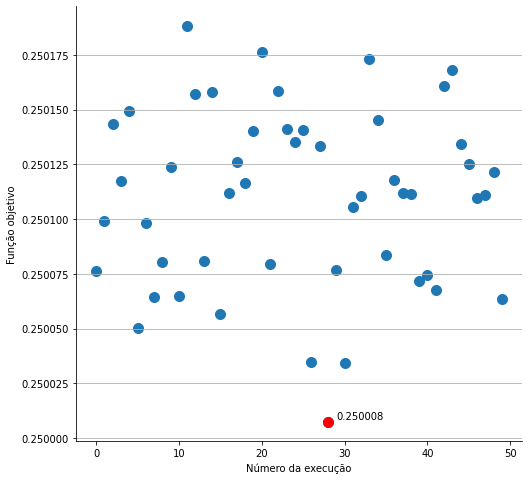

In [ ]:
import matplotlib.pyplot as plt

figure, ax = plt.subplots(figsize=(8, 8))

plt.grid(axis='y')

plt.xlabel('Número da execução')
plt.ylabel('Função objetivo')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

minimo_funcao_objetivo = np.argmin(exec_df["funcao objetivo"])

# Annotation
ax.annotate(str(np.round(exec_df["funcao objetivo"][minimo_funcao_objetivo], 6)), xy=(exec_df["execucao"][minimo_funcao_objetivo], exec_df["funcao objetivo"][minimo_funcao_objetivo]), xytext=(exec_df["execucao"][minimo_funcao_objetivo] + 1, exec_df["funcao objetivo"][minimo_funcao_objetivo] + 0.000001))

plt.scatter(exec_df["execucao"], exec_df["funcao objetivo"], s=100)
plt.scatter(exec_df["execucao"][minimo_funcao_objetivo], exec_df["funcao objetivo"][minimo_funcao_objetivo], s=100, color='red')
# plt.scatter(attack_df['timestamp'], attack_df['flag'], color='red')

# Para o melhor resultado, imprima:

## Retreino do modelo com melhor seed

In [ ]:
from sklearn.preprocessing import StandardScaler

best_model = VectorizedMVFCMddV(random_state=28)
best_model.fit_predict(features)

self.vector_of_medoid_vectors  [[10790 19153  2603]
 [15878 12278 16742]
 [14347  9102 20665]
 [13821 12090 14434]
 [ 6293 17878  6312]
 [15452  2233  9578]
 [ 1870 14807 19955]
 [ 6894  5673  4867]
 [ 9135  7771 11720]
 [19668  3651 16795]
 [13724 14630  2766]
 [20480 12823  5540]]
t = 0
t = 1
t = 2
t = 3
t = 4


## Os protótipos

In [ ]:
print("Os indices dos prototipos obtidos foram: \n", best_model.vector_of_medoid_vectors)

Os indices dos prototipos obtidos foram: 
 [[19808  2185 16169]
 [19808  2185 16169]
 [ 8526  2185  9677]
 [19808  2185  9677]
 [ 8447  5462 14210]
 [19808  9503 16169]
 [19808  2185 16169]
 [19808  2185 16169]
 [19808  2185 16169]
 [19808  2185 16169]
 [ 3818  9503 16476]
 [19808  2185 16169]]


In [ ]:
for p in range(best_model.p):
  print(f"Os prototipos da matriz de dissimilaridade {p} pertenciam as seguintes classes: \n")
  print(labels_df[best_model.vector_of_medoid_vectors[:, p]])
  print('\n\n\n')

Os prototipos da matriz de dissimilaridade 0 pertenciam as seguintes classes: 

19808    A
19808    A
8526     A
19808    A
8447     A
19808    A
19808    A
19808    A
19808    A
19808    A
3818     A
19808    A
Name: Class, dtype: object




Os prototipos da matriz de dissimilaridade 1 pertenciam as seguintes classes: 

2185    F
2185    F
2185    F
2185    F
5462    F
9503    A
2185    F
2185    F
2185    F
2185    F
9503    A
2185    F
Name: Class, dtype: object




Os prototipos da matriz de dissimilaridade 2 pertenciam as seguintes classes: 

16169    A
16169    A
9677     A
9677     A
14210    A
16169    A
16169    A
16169    A
16169    A
16169    A
16476    A
16169    A
Name: Class, dtype: object






In [ ]:
for p in range(best_model.p):
  print(f"Os valores das features referentes aos prototipos da matriz de dissimilaridade {p} foram: \n")
  print(features[best_model.vector_of_medoid_vectors[:, p]])
  print("\n\n\n")

Os valores das features referentes aos prototipos da matriz de dissimilaridade 0 foram: 

[[ 0.068573  0.148427  0.111153  0.179577  0.261718  0.024215  0.106925
   0.024094  0.001721  0.072657]
 [ 0.068573  0.148427  0.111153  0.179577  0.261718  0.024215  0.106925
   0.024094  0.001721  0.072657]
 [ 0.056229  0.124874  0.136047  0.14974   0.17234   0.107265  0.106925
  -0.057975 -0.029461  0.165012]
 [ 0.068573  0.148427  0.111153  0.179577  0.261718  0.024215  0.106925
   0.024094  0.001721  0.072657]
 [ 0.167323  0.117022  0.047137 -0.174809  0.261718 -0.224934  0.106925
  -0.091001  0.126447 -0.143274]
 [ 0.068573  0.148427  0.111153  0.179577  0.261718  0.024215  0.106925
   0.024094  0.001721  0.072657]
 [ 0.068573  0.148427  0.111153  0.179577  0.261718  0.024215  0.106925
   0.024094  0.001721  0.072657]
 [ 0.068573  0.148427  0.111153  0.179577  0.261718  0.024215  0.106925
   0.024094  0.001721  0.072657]
 [ 0.068573  0.148427  0.111153  0.179577  0.261718  0.024215  0.10692

## A matriz de confusão da partição crisp vs. partição a priori

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Criação da partição crisp
crisp_partition_values = crisp_partition(best_model.vector_of_membership_degree_vectors)
crisp_partition_values

# Seleção dos valores das partições a priori
labels = labels_df.to_numpy()

# Encoder para transformar as variáveis categóricas em variáveis numericas
le = preprocessing.LabelEncoder()
le.fit(labels)

# Transforma as variaveis categoricas em variaveis numericas
labels_transformed = le.transform(labels)
crisp_cat = le.inverse_transform(crisp_partition_values.astype(int))

In [ ]:
labels_unique, labels_count = np.unique(labels_df, return_counts=True)

print("As labels presentes no dataset são: \n", labels_unique)
print("A quantidade de dados presente em cada label é de: \n", labels_count)

As labels presentes no dataset são: 
 ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'W' 'X' 'Y']
A quantidade de dados presente em cada label é de: 
 [8572   10  206  705 2190 3923  893 1039 1663   89 1044  533]


In [ ]:
labels_num_unique, labels_num_count = np.unique(labels_transformed, return_counts=True)

print("As labels presentes no dataset são: \n", labels_num_unique)
print("A quantidade de dados presente em cada label é de: \n", labels_num_count)

As labels presentes no dataset são: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11]
A quantidade de dados presente em cada label é de: 
 [8572   10  206  705 2190 3923  893 1039 1663   89 1044  533]


In [ ]:
crisp_unique, crisp_count = np.unique(crisp_partition_values, return_counts=True)

print("As partições crisp obtidas foram: \n", crisp_unique)
print("A quantidade de dados presente em cada partição crisp é de: \n", crisp_count)

As partições crisp obtidas foram: 
 [ 1.  2.  3.  4.  5.  9. 10.]
A quantidade de dados presente em cada partição crisp é de: 
 [ 191 4767 1057 7854 1052  849 5097]


In [ ]:
conf_matrix = confusion_matrix(labels_transformed, crisp_partition_values)

def conf_matrix_sum(conf_matrix):
  conf_matrix_sum_array = conf_matrix
  conf_matrix_sum_array = np.concatenate((conf_matrix_sum_array, np.atleast_2d(np.sum(conf_matrix_sum_array, axis=1)).T), axis=1)
  conf_matrix_sum_array = np.concatenate((conf_matrix_sum_array, np.atleast_2d(np.sum(conf_matrix_sum_array, axis=0))), axis=0)

  return conf_matrix_sum_array

conf_matrix_sum = conf_matrix_sum(conf_matrix)

In [ ]:
conf_matrix_sum_df = pd.DataFrame(conf_matrix_sum)
conf_matrix_sum_df = conf_matrix_sum_df.rename(columns = {12:'Sum'})
conf_matrix_sum_df.index = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'W', 'X', 'Y', 'Sum']
conf_matrix_sum_df

,0,1,2,3,4,5,6,7,8,9,10,11,Sum
A,0,106,2423,276,2865,579,0,0,0,533,1790,0,8572
B,0,0,3,6,0,1,0,0,0,0,0,0,10
C,0,0,36,3,123,10,0,0,0,1,33,0,206
D,0,1,179,7,336,24,0,0,0,12,146,0,705
E,0,14,477,105,668,61,0,0,0,43,822,0,2190
F,0,54,680,62,1943,272,0,0,0,143,769,0,3923
G,0,8,195,46,399,40,0,0,0,43,162,0,893
H,0,8,109,35,598,28,0,0,0,21,240,0,1039
I,0,0,170,308,747,2,0,0,0,34,402,0,1663
W,0,0,25,5,13,3,0,0,0,0,43,0,89


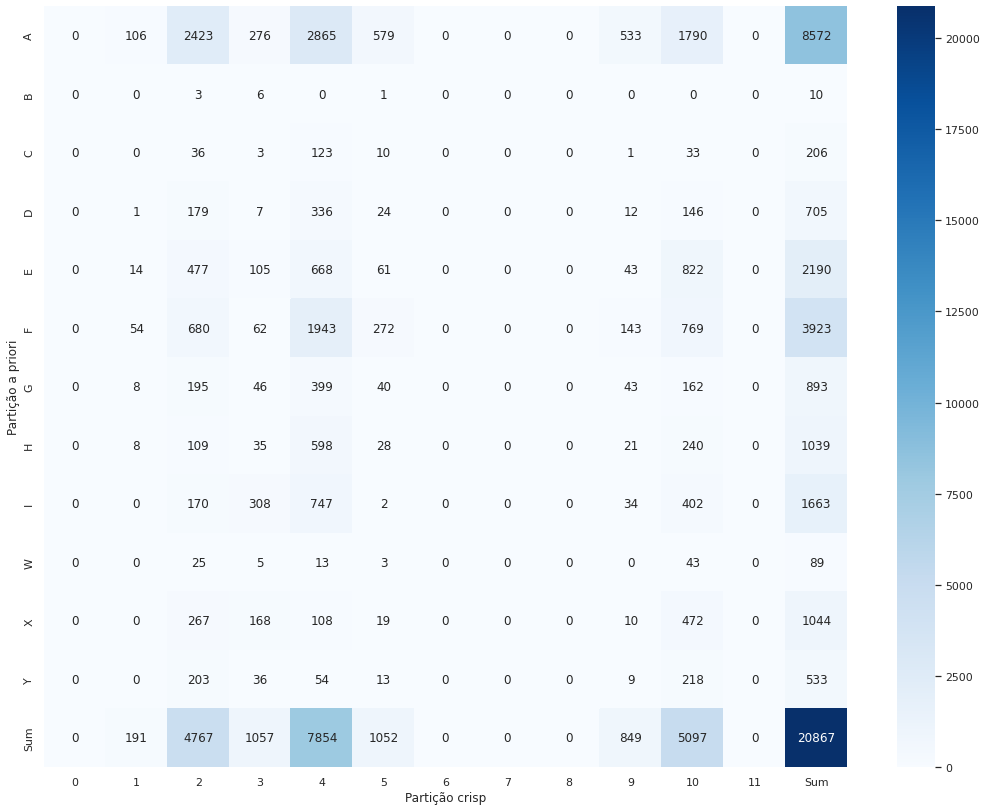

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(labels_transformed, crisp_partition_values)

sns.set(rc={'figure.figsize':(18, 14)})
ax = sns.heatmap(conf_matrix_sum_df, annot=True, cmap='Blues', fmt='g')

# todo:
# ver como fazer para colocar os somatorios no final
# de cada grupo e cada classe
# GRUPO E CLASSE SAO COISAS DIFERENTES
ax.set(xlabel='Partição crisp', ylabel='Partição a priori')
plt.show()

## A matriz de pesos de relevância das matrizes de dissimilaridade

In [ ]:
print("A matriz de pesos de relevância das matrizes de dissimilaridade é dada por:\n", best_model.vector_of_relevance_weight_vectors)

A matriz de pesos de relevância das matrizes de dissimilaridade é dada por:
 [[0.99628875 0.93124117 1.07782585]
 [0.99628872 0.93124099 1.0778261 ]
 [0.99572477 0.93238433 1.07711434]
 [0.96991905 1.01228383 1.01850178]
 [0.99572477 0.93238433 1.07711434]
 [0.99572477 0.93238433 1.07711435]
 [0.99572477 0.93238433 1.07711434]
 [0.99572477 0.93238433 1.07711435]
 [0.99628872 0.93124099 1.07782609]
 [0.99628872 0.93124099 1.07782609]
 [0.99572477 0.93238433 1.07711434]
 [0.99572477 0.93238433 1.07711435]]


# Calcula o Modified partition coefficient e o Partition entropy. 

Comente sobre os resultados obtidos

In [ ]:
mpc = modified_partition_coefficient(best_model.vector_of_membership_degree_vectors)
print("Modified partition coefficient = ", mpc)

Modified partition coefficient =  0.00021815203108854764


In [ ]:
pe = partition_entropy_coeficient(best_model.vector_of_membership_degree_vectors)
print("Partition entropy = ", pe)

Partition entropy =  2.4836942949737644


# Produza uma partição crisp em 12 grupos e calcule o índice de Rand corrigido, e a F-measure (adaptada para agrupamento). 

Comente sobre os resultados obtidos

In [ ]:
# Adjusted rand score reference:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
from sklearn.metrics.cluster import adjusted_rand_score

indice_rand_corrigido = adjusted_rand_score(labels_transformed, crisp_partition_values)

print("Indice de rand corrigido = ", indice_rand_corrigido)

Indice de rand corrigido =  0.003678045450584269


In [ ]:
def compute_f_measure_matrix(conf_matrix):
  m = conf_matrix.shape[0]
  K = conf_matrix.shape[1]

  f_measure_matrix = np.zeros((m, K))

  i = np.arange(m)
  j = np.arange(K)

  for i, j in itertools.product(i, j):
    f_measure_matrix[i, j] = (2 * conf_matrix[i, j]) / (np.sum(conf_matrix[:, j]) + np.sum(conf_matrix[i, :]))

  return f_measure_matrix


def f_measure_adapted_for_clustering(conf_matrix):
  f_measure_matrix = compute_f_measure_matrix(conf_matrix)

  m = conf_matrix.shape[0]
  K = conf_matrix.shape[1]

  i = np.arange(m)
  j = np.arange(K)

  f_measure = 0
  for i, j in itertools.product(i, j):
    f_measure = np.sum(conf_matrix[i, :]) * f_measure_matrix[i, np.argmax(f_measure_matrix[i, :])]

  f_measure = f_measure / np.sum(conf_matrix)

  return f_measure

# f_measure_m = compute_f_measure_matrix(conf_matrix)
f_measure_clustering = f_measure_adapted_for_clustering(conf_matrix)

print("F measure igual a ", f_measure_clustering)

F measure igual a  0.0019780865382642895
